# Spatial Analysis
Leverage spatial coordinates to identify spatially variable genes, compute spatial statistics, analyze tissue architecture, and detect co-expression patterns unique to spatial regions.

In [2]:
# IMPORTS & PATHS 
from __future__ import annotations
from pathlib import Path
import warnings, os, tempfile
warnings.filterwarnings('ignore')
os.environ.setdefault('NUMBA_CACHE_DIR',
    str(Path(tempfile.gettempdir()) / 'numba_cache'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc
import squidpy as sq

rcParams['font.family'] = 'DejaVu Sans'
sc.settings.verbosity  = 3

cwd = Path.cwd().resolve()
if (cwd / 'README.md').exists() and (cwd / 'data').exists():
    project_root = cwd
elif (cwd.parent / 'README.md').exists():
    project_root = cwd.parent
else:
    raise RuntimeError(f'Cannot locate project root from cwd={cwd}.')

processed_dir  = project_root / 'data' / 'processed'
fig_sp_dir     = project_root / 'figures' / 'spatial'
fig_svg_dir    = project_root / 'figures' / 'svg'
fig_nhood_dir  = project_root / 'figures' / 'neighborhood'

for d in [fig_sp_dir, fig_svg_dir, fig_nhood_dir]:
    d.mkdir(parents=True, exist_ok=True)

sc.settings.figdir = str(fig_svg_dir)
print(f"Scanpy  : {sc.__version__}")
print(f"Squidpy : {sq.__version__}")

Scanpy  : 1.12
Squidpy : 1.8.1


In [3]:
# LOAD ANNOTATED ADATA 
adata = sc.read_h5ad(processed_dir / 'adata_annotated.h5ad')

print(adata)
print(f"\nSpots       : {adata.n_obs:,}")
print(f"Genes       : {adata.n_vars:,}")
print(f"Cell types  : {adata.obs['cell_type'].nunique()}")
print(f"Clusters    : {adata.obs['leiden'].unique().tolist()}")

AnnData object with n_obs × n_vars = 4869 × 21349
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'leiden_0.3', 'leiden_0.5', 'leiden_0.6', 'leiden_1.0', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_leiden', 'hvg', 'leiden_0.3', 'leiden_0.3_colors', 'leiden_0.5', 'leiden_0.5_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_1.0', 'leiden_1.0_colors', 'lo

In [6]:
# ── CELL 3 : BUILD SPATIAL NEIGHBORS GRAPH ───────────────
sq.gr.spatial_neighbors(
    adata,
    coord_type='grid',    # ← 'visium' renamed to 'grid' in newer squidpy
    n_neighs=6,
    key_added='spatial'
)

print("    Spatial neighbors graph built")
print(f"   Connectivities shape : {adata.obsp['spatial_connectivities'].shape}")
print(f"   Non-zero connections : {adata.obsp['spatial_connectivities'].nnz:,}")

INFO     Creating graph using `grid` coordinates and `None` transform and `1` libraries.                           
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
    Spatial neighbors graph built
   Connectivities shape : (4869, 4869)
   Non-zero connections : 28,578


In [8]:
# SPATIALLY VARIABLE GENES — MORAN'S I 
# Moran's I measures spatial autocorrelation
# I close to +1 = gene is spatially clustered (interesting!)
# I close to  0 = random spatial distribution
# I close to -1 = spatially dispersed (checkerboard)

sq.gr.spatial_autocorr(
    adata,
    mode='moran',
    n_perms=100,         # permutation test for significance
    n_jobs=1,
    attr='X',
    use_raw=False,
)

print(" Moran's I computed")
print(f"   Results stored in : adata.uns['moranI']")

# View top SVGs
moranI = adata.uns['moranI']
print(f"\nTotal genes tested : {len(moranI):,}")
print(f"Significant SVGs   : {(moranI['pval_sim_fdr_bh'] < 0.05).sum():,}")
print(f"\nTop 15 Spatially Variable Genes:")
print(moranI.head(15)[['I', 'pval_sim', 'pval_sim_fdr_bh']].round(4))

Calculating moran's statistic for `100` permutations using `1` core(s)


100%|██████████| 100/100 [07:02<00:00,  4.23s/]


Adding `adata.uns['moranI']`
Finish (0:07:03)
 Moran's I computed
   Results stored in : adata.uns['moranI']

Total genes tested : 3,000
Significant SVGs   : 2,486

Top 15 Spatially Variable Genes:
              I  pval_sim  pval_sim_fdr_bh
MGP      0.8384    0.0099           0.0128
IGLC2    0.8296    0.0099           0.0128
IGHG3    0.8180    0.0099           0.0128
IGKC     0.8023    0.0099           0.0128
COX6C    0.8017    0.0099           0.0128
MT-ND1   0.7735    0.0099           0.0128
MT-CO1   0.7651    0.0099           0.0128
FTL      0.7523    0.0099           0.0128
IGHG4    0.7397    0.0099           0.0128
CXCL14   0.7265    0.0099           0.0128
IGHG1    0.6998    0.0099           0.0128
GAPDH    0.6972    0.0099           0.0128
SCGB1D2  0.6942    0.0099           0.0128
IGLC3    0.6901    0.0099           0.0128
CD74     0.6847    0.0099           0.0128


Top SVGs: ['MGP', 'IGLC2', 'IGHG3', 'IGKC', 'COX6C', 'MT-ND1', 'MT-CO1', 'FTL']
Saved → figures/svg/01_top_svgs_spatial.png


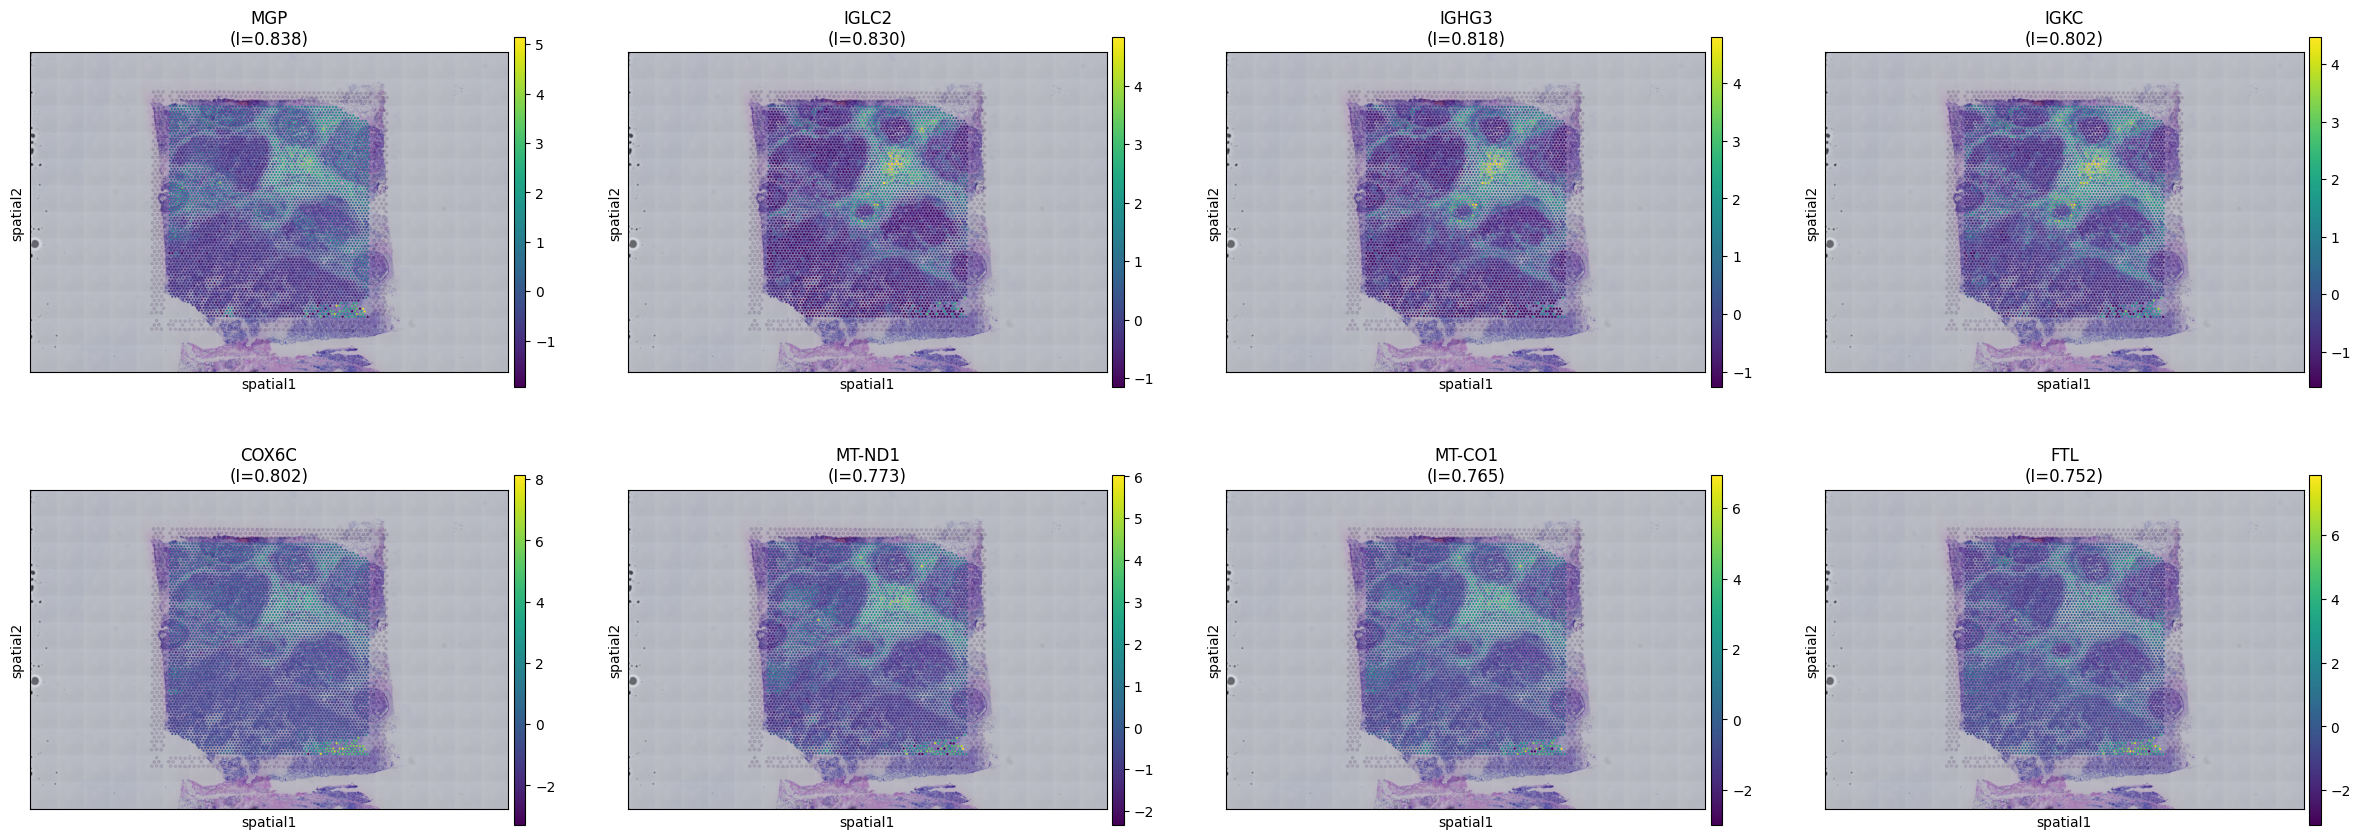

In [9]:
# PLOT TOP SVGs ON TISSUE 
# Get top 8 SVGs
top_svgs = adata.uns['moranI'].head(8).index.tolist()
print(f"Top SVGs: {top_svgs}")

# Filter to genes actually in adata
top_svgs = [g for g in top_svgs if g in adata.var_names]

prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_svg_dir)

sq.pl.spatial_scatter(
    adata,
    color=top_svgs,
    ncols=4,
    use_raw=False,
    title=[f'{g}\n(I={adata.uns["moranI"].loc[g,"I"]:.3f})'
           for g in top_svgs],
    save='_01_top_svgs_spatial.png'
)

sc.settings.figdir = prev_figdir
print("Saved → figures/svg/01_top_svgs_spatial.png")

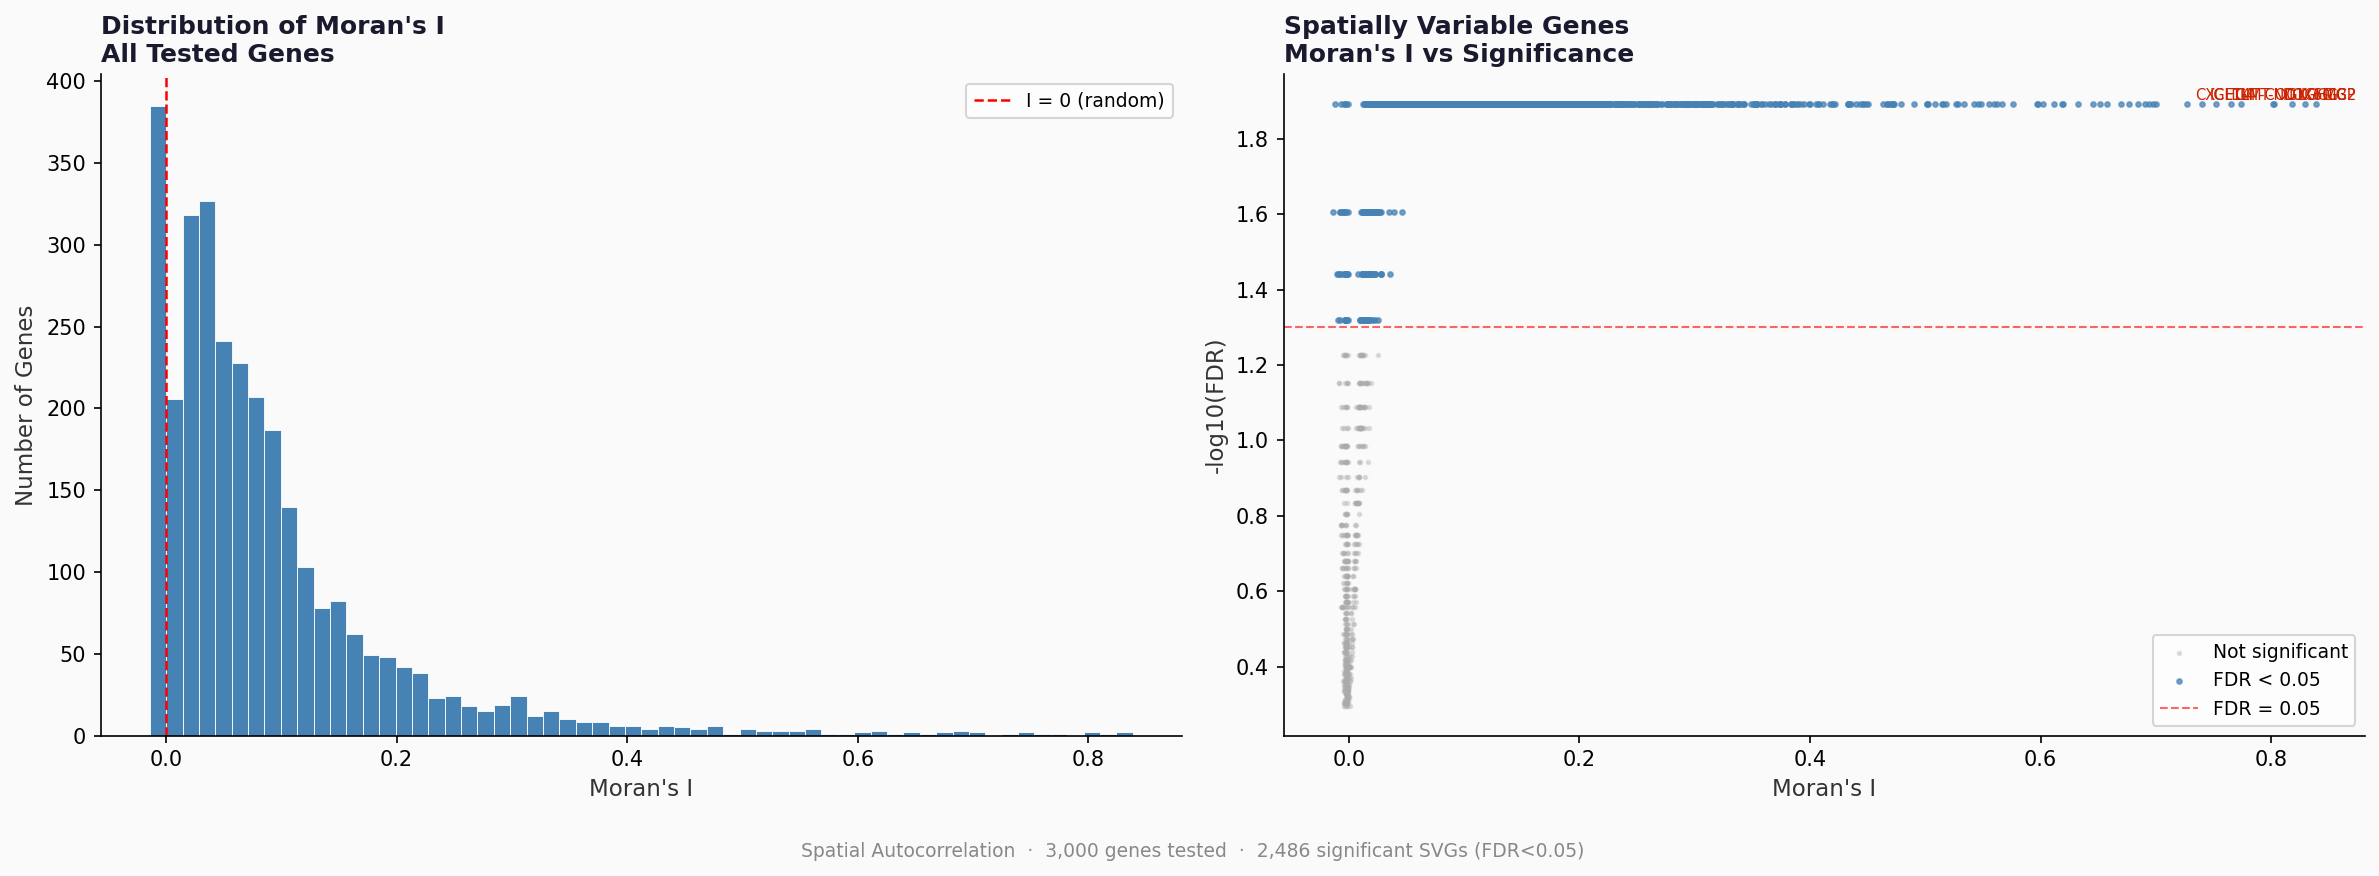

Saved → C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\figures\svg\02_moranI_summary.png


In [10]:
# SVG SUMMARY PLOT 
moranI = adata.uns['moranI'].copy()
moranI['-log10(FDR)'] = -np.log10(moranI['pval_sim_fdr_bh'] + 1e-10)
moranI['significant']  = moranI['pval_sim_fdr_bh'] < 0.05

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=150)
fig.patch.set_facecolor('#FAFAFA')

# LEFT: Moran's I distribution
axes[0].hist(moranI['I'], bins=60, color='steelblue',
             edgecolor='white', linewidth=0.4)
axes[0].axvline(0, color='red', linestyle='--',
                linewidth=1.2, label='I = 0 (random)')
axes[0].set_xlabel("Moran's I", fontsize=11, color='#333')
axes[0].set_ylabel('Number of Genes', fontsize=11, color='#333')
axes[0].set_title("Distribution of Moran's I\nAll Tested Genes",
                  fontsize=12, fontweight='bold',
                  loc='left', color='#1a1a2e')
axes[0].legend(fontsize=9)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_facecolor('#FAFAFA')

# RIGHT: Volcano-style — I vs -log10(FDR)
sig   = moranI[moranI['significant']]
nonsig= moranI[~moranI['significant']]

axes[1].scatter(nonsig['I'], nonsig['-log10(FDR)'],
                s=3, alpha=0.3, color='#aaaaaa', label='Not significant')
axes[1].scatter(sig['I'],    sig['-log10(FDR)'],
                s=5, alpha=0.7, color='steelblue', label='FDR < 0.05')

# Label top 10
for gene in moranI.head(10).index:
    if gene in adata.var_names:
        axes[1].annotate(
            gene,
            xy=(moranI.loc[gene,'I'], moranI.loc[gene,'-log10(FDR)']),
            fontsize=7, color='#cc2200',
            xytext=(4, 2), textcoords='offset points'
        )

axes[1].axhline(-np.log10(0.05), color='red', linestyle='--',
                linewidth=1, alpha=0.6, label='FDR = 0.05')
axes[1].set_xlabel("Moran's I", fontsize=11, color='#333')
axes[1].set_ylabel('-log10(FDR)', fontsize=11, color='#333')
axes[1].set_title("Spatially Variable Genes\nMoran's I vs Significance",
                  fontsize=12, fontweight='bold',
                  loc='left', color='#1a1a2e')
axes[1].legend(fontsize=9, framealpha=0.8)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_facecolor('#FAFAFA')

fig.suptitle(
    f"Spatial Autocorrelation  ·  {len(moranI):,} genes tested  "
    f"·  {moranI['significant'].sum():,} significant SVGs (FDR<0.05)",
    fontsize=9, color='#888888', y=0.01
)

plt.tight_layout(rect=[0, 0.03, 1, 1])
out = fig_svg_dir / '02_moranI_summary.png'
plt.savefig(out, dpi=200, bbox_inches='tight', facecolor='#FAFAFA')
plt.show()
print(f"Saved → {out}")

In [12]:
# NEIGHBORHOOD ENRICHMENT 
# Tests which cluster pairs are spatially enriched
# or depleted in each other's neighborhoods
# Positive score = clusters co-localize on tissue
# Negative score = clusters avoid each other spatially

sq.gr.nhood_enrichment(
    adata,
    cluster_key='cell_type',
    seed=42
)

print("    Neighborhood enrichment computed")
print(f"   Z-score matrix shape : {adata.uns['cell_type_nhood_enrichment']['zscore'].shape}")

Calculating neighborhood enrichment using `1` core(s)


100%|██████████| 1000/1000 [00:03<00:00, 296.65/s]


Adding `adata.uns['cell_type_nhood_enrichment']`
Finish (0:00:03)
    Neighborhood enrichment computed
   Z-score matrix shape : (9, 9)


Saved → figures/neighborhood/03_nhood_enrichment.png


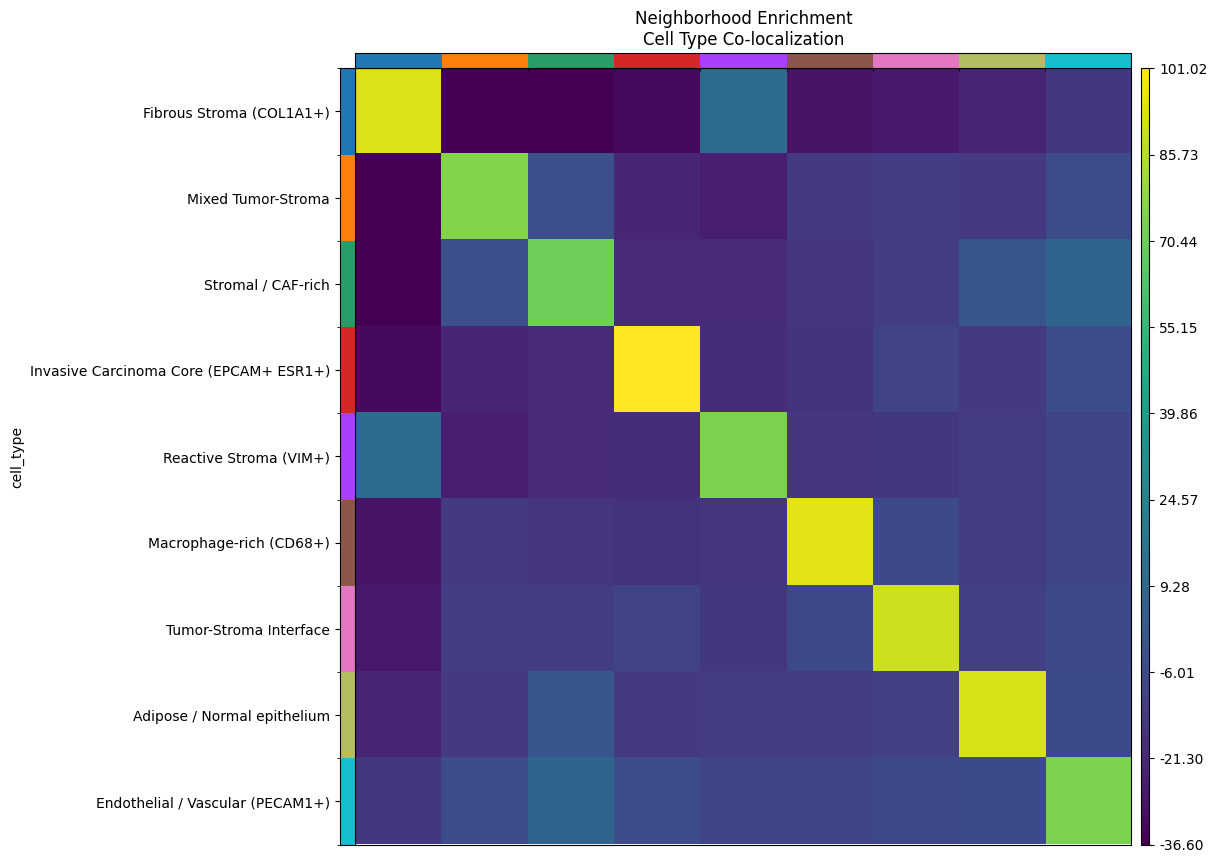

In [13]:
# NEIGHBORHOOD ENRICHMENT PLOT
prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_nhood_dir)

sq.pl.nhood_enrichment(
    adata,
    cluster_key='cell_type',
    title='Neighborhood Enrichment\nCell Type Co-localization',
    figsize=(10, 8),
    save='_03_nhood_enrichment.png'
)

sc.settings.figdir = prev_figdir
print("Saved → figures/neighborhood/03_nhood_enrichment.png")

In [16]:
# CO-OCCURRENCE 
# Probability that two cell types occur near each other
# at increasing spatial distances (interval bins)

sq.gr.co_occurrence(
    adata,
    cluster_key='cell_type',
    n_splits=10,
    n_jobs=1,
)

print("Co-occurrence computed")

Calculating co-occurrence probabilities for `50` intervals using `1` core(s) and `10` splits
Adding `adata.uns['cell_type_co_occurrence']`
Finish (0:00:00)
Co-occurrence computed


Saved → figures/neighborhood/04_co_occurrence_tumor.png


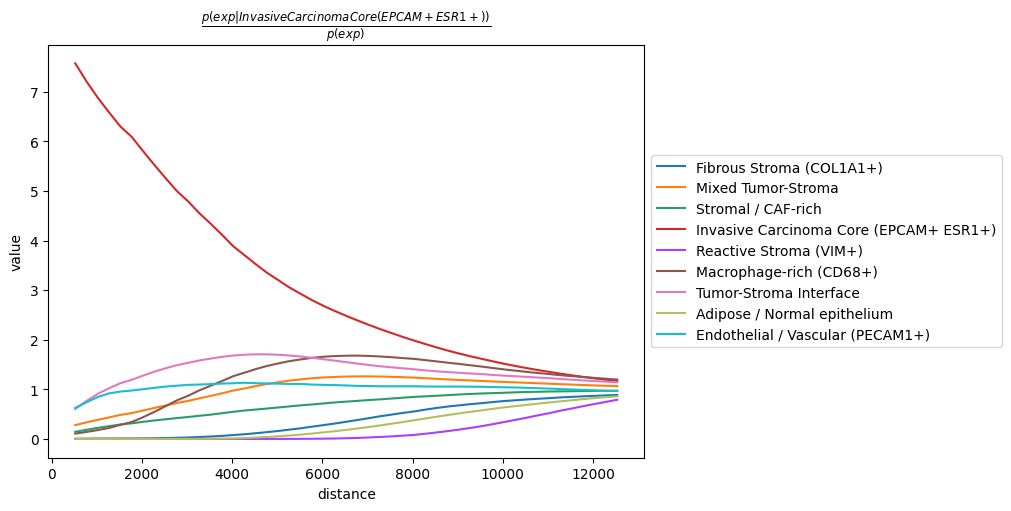

In [17]:
# CO-OCCURRENCE PLOT 
# Focus on Invasive Carcinoma Core interactions
# Change cluster name to match yours exactly

tumor_cluster = 'Invasive Carcinoma Core (EPCAM+ ESR1+)'

prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_nhood_dir)

sq.pl.co_occurrence(
    adata,
    cluster_key='cell_type',
    clusters=tumor_cluster,
    figsize=(10, 5),
    save='_04_co_occurrence_tumor.png'
)

sc.settings.figdir = prev_figdir
print("Saved → figures/neighborhood/04_co_occurrence_tumor.png")

Calculating Ripley's L statistic for `9` clusters and `50` simulations
Adding `adata.uns['cell_type_ripley_L']`
Finish (0:00:01)
Saved figures/neighborhood/05_ripley_L.png


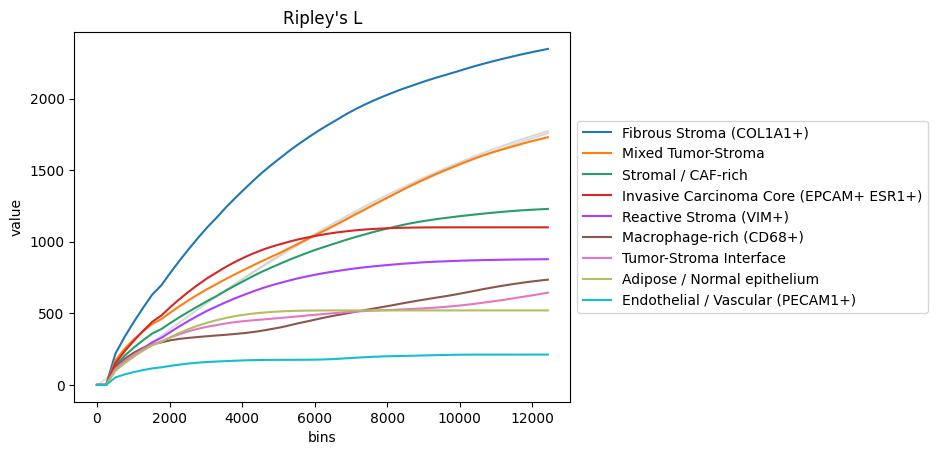

In [19]:
# RIPLEY'S L STATISTIC 
# Tests if cell types are spatially clustered (L > 0)
# random (L ≈ 0) or dispersed (L < 0)

sq.gr.ripley(
    adata,
    cluster_key='cell_type',
    mode='L',
    n_simulations=50,
)

prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_nhood_dir)

sq.pl.ripley(
    adata,
    cluster_key='cell_type',
    mode='L',
    save='_05_ripley_L.png'
)

sc.settings.figdir = prev_figdir
print("Saved figures/neighborhood/05_ripley_L.png")

In [21]:
# SAVE ADATA WITH SPATIAL STATS 
out_path = processed_dir / 'adata_spatial.h5ad'
adata.write_h5ad(out_path)

print(f"   Saved -> {out_path}")
print(f"   Shape : {adata.n_obs:,} spots × {adata.n_vars:,} genes")
print(f"   Size  : {out_path.stat().st_size / 1e6:.1f} MB")

   Saved -> C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\data\processed\adata_spatial.h5ad
   Shape : 4,869 spots × 21,349 genes
   Size  : 1180.1 MB


In [24]:
# SUMMARY 
moranI = adata.uns['moranI']
n_sig  = (moranI['pval_sim_fdr_bh'] < 0.05).sum()
top5   = moranI.head(5).index.tolist()

print('\n' + '=' * 55)
print('  NOTEBOOK 04 — SPATIAL ANALYSIS COMPLETE')
print('=' * 55)
print(f'  SVGs significant    : {n_sig:,}  (FDR < 0.05)')
print(f'  Top 5 SVGs          : {", ".join(top5)}')
print(f'  Neighborhood enrich : computed ')
print(f'  Co-occurrence       : computed ')
print(f'  Ripley L            : computed ')
print(f'  Saved to            : data/processed/adata_spatial.h5ad')
print('=' * 55)
print('\n→ Next: 05_Deconvolution.ipynb')


  NOTEBOOK 04 — SPATIAL ANALYSIS COMPLETE
  SVGs significant    : 2,486  (FDR < 0.05)
  Top 5 SVGs          : MGP, IGLC2, IGHG3, IGKC, COX6C
  Neighborhood enrich : computed 
  Co-occurrence       : computed 
  Ripley L            : computed 
  Saved to            : data/processed/adata_spatial.h5ad

→ Next: 05_Deconvolution.ipynb
